In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#import seaborn as sn
from sklearn.model_selection import train_test_split

from random import seed
seed(1)
seed = 43

import tensorflow as tf
from tensorflow import keras
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ",keras.__version__)


kaggle = 0 # Kaggle path active = 1

# change your local path here
if kaggle == 1 :
    MNIST_PATH= '../input/digit-recognizer'
else:
    MNIST_PATH= '../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer'



import os
for dirname, _, filenames in os.walk(MNIST_PATH): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

Tensorflow Version:  2.3.0
Keras Version:  2.4.0
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\keras_reg_160_10_002.sav
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\keras_reg_jl_160_10_002.sav
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\sample_submission.csv
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\test.csv
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\train.csv


# Introduction - MNIST Training Competition
This notebook is a fork of my previous developed notebook for digit recognition. Therefore you will find some parts that look common the the notebook <a href="https://www.kaggle.com/skiplik/digit-recognition-with-a-deep-neural-network">Digit Recognition with a Deep Neural Network</a> and some parts that are completely different.

With this I want to take a deeper look in the parts of finetuning hyperparameters based on the following parts:
- Dwindling / Exploding Gradients
- Optimizers
- Regulations 

Link to the data topic: https://www.kaggle.com/c/digit-recognizer/data

As in the previous notebooks I will use Tensorflow with Keras. I already mentioned in other notebooks, I will skip some explanations about the data set here. Moreover I will use the already discovered knowledge about the data and transform/prepare the data rightaway.

If you are interested in some more clearly analysis of the dataset take a look into my other notebooks about the MNIS-dataset:
- Digit Recognition with a Deep Neural Network: https://www.kaggle.com/skiplik/digit-recognition-with-a-deep-neural-network
- Another MNIST Try: https://www.kaggle.com/skiplik/another-mnist-try
- First NN by Detecting Handwritten Characters: https://www.kaggle.com/skiplik/first-nn-by-detecting-handwritten-characters
...


# Get Data

In [21]:
# Data path and file
CSV_FILE_TRAIN='train.csv'
CSV_FILE_TEST='test.csv'

def load_mnist_data(minist_path, csv_file):
    csv_path = os.path.join(minist_path, csv_file)
    return pd.read_csv(csv_path)

def load_mnist_data_manuel(minist_path, csv_file):
    csv_path = os.path.join(minist_path, csv_file)
    csv_file = open(csv_path, 'r')
    csv_data = csv_file.readlines()
    csv_file.close()
    return csv_data

def split_train_val(data, val_ratio):
    return 
    

train = load_mnist_data(MNIST_PATH,CSV_FILE_TRAIN)
test = load_mnist_data(MNIST_PATH,CSV_FILE_TEST)

In [22]:
y = train['label'].copy()
X = train.drop(['label'], axis=1)

X_test = test.copy()

## Train / Val Split

In [23]:
print("Shape of the Features: ",X.shape)
print("Shape of the Labels: ", y.shape)

Shape of the Features:  (42000, 784)
Shape of the Labels:  (42000,)


### Label Value Count
Visualizing the label distribution of the full train dataset.

In [24]:
train.value_counts('label')

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
dtype: int64

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.15
                                                  , stratify=y
                                                 )

Comparing the equally splitted train- and val-sets based on the given label y.

In [26]:
print("Train - Set Distribution")
print(y_train.value_counts() / y_train.value_counts().sum() )
print('--------------------------------------------------------------')
print('--------------------------------------------------------------')
print('--------------------------------------------------------------')
print("Val - Set Distribution")
print(y_val.value_counts() / y_val.value_counts().sum() )


Train - Set Distribution
1    0.111513
7    0.104790
3    0.103585
9    0.099720
2    0.099440
6    0.098515
0    0.098375
4    0.096947
8    0.096751
5    0.090364
Name: label, dtype: float64
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
Val - Set Distribution
1    0.111587
7    0.104762
3    0.103651
9    0.099683
2    0.099524
6    0.098413
0    0.098413
4    0.096984
8    0.096667
5    0.090317
Name: label, dtype: float64


In [27]:
print("X: ", X.shape)
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)

print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)

X:  (42000, 784)
X_train:  (35700, 784)
X_val:  (6300, 784)
y_train:  (35700,)
y_val:  (6300,)


## Building Transforming Piplines

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('normalizer', Normalizer())
    #('std_scalar',StandardScaler())
])

In [29]:
X_train_prep = pipeline.fit_transform(X_train)      # fitting the pipeline to the train and transform it
X_val_prep = pipeline.transform(X_val)              # transform val data with this information

# Building a Deep Neural Network based on RandomizedSearch

## Preparing Model Visualization with Tensorboard (not for Kaggle)

In [30]:
root_logdir = "../../tensorboard-logs"

print("Relative root_logdir: ",root_logdir)

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir,run_id)

Relative root_logdir:  ../../tensorboard-logs


In [31]:
run_logdir = get_run_logdir()
print("Current run logdir for Tensorboard: ", run_logdir)

Current run logdir for Tensorboard:  ../../tensorboard-logs\run_2021_09_07-09_27_15


In [32]:
run_logdir

'../../tensorboard-logs\\run_2021_09_07-09_27_15'

### Keras Callbacks for Tensorboard
With Keras there is a way of using Callbacks for the Tensorboard to write log files for the board and visualize the different graphs (loss and val curve)


In [33]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

## Building Model Architecture

### Architecture for Hyperparameter Optimization
- Amount of Layers
- Amount of Neurons
- Learningrate
- Checkpoints
- Early Stopping 

In [34]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[784]):
    model = keras.models.Sequential()                               # base model structure (Sequential API by Keras)

    model.add(keras.layers.InputLayer(input_shape=input_shape))     # input layer

    for layer in range(n_hidden):                                   # add layers as often as defined in constructor 
        model.add(keras.layers.Dense(n_neurons,activation="relu"))  # add layer with given neurons and relu activation function

    model.add(keras.layers.Dense(10, activation="softmax"))                               # add output layer 

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)   # define optimizer (especially the larning rate for hyperparameter optimization)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])                  # make it ready

    return model


In [35]:
# Using keras wrapper as hull 
keras_cl = keras.wrappers.scikit_learn.KerasClassifier(build_model)

### Hyperparameter Space

In [36]:
from scipy.stats import reciprocal

# Hyperparameter set
param_dist= {
            "n_neurons": range(20, 500, 20)
            ,"n_hidden": range(10, 100, 10)
            ,"learning_rate": [1e-3, 2e-3]
    }


param_dist_lr= {
        "n_neurons": [10, 50, 100, 150, 300]
        ,"n_hidden": [10, 50, 100, 150]
        ,"learning_rate": [1e-3, 3e-4, 3e-2]
}


param_dist_bestrun_1 = {
        "n_neurons": [150]
        ,"n_hidden": [30]
        ,"learning_rate": [2e-3]  
}


param_dist_bestrun_2 = {
        "n_neurons": [100]
        ,"n_hidden": [10]
        ,"learning_rate": [2e-3]  
}

## Model Checkpoints

In [37]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cl_model.h5", save_best_only=True, save_weights_only=False)

## Model Training

### Randomized Search
Finding best hyperparameters with Randomized search

In [38]:
from sklearn.model_selection import RandomizedSearchCV

ran_ker_cl = RandomizedSearchCV(keras_cl, param_dist_lr, n_iter=10, n_jobs=5, cv=3, random_state=seed, return_train_score=True)
history_ker_cl = ran_ker_cl.fit(X_train_prep, y_train, epochs=100, validation_data=(X_val_prep, y_val), callbacks=[checkpoint_cb, keras.callbacks.EarlyStopping(patience=5), tensorboard_cb])

Epoch 1/100
   1/1116 [..............................] - ETA: 0s - loss: 2.3028 - accuracy: 0.0312WARNING:tensorflow:From D:\anaconda3\envs\wingpuflake_keras\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1116/1116 [==============================] - 5s 5ms/step - loss: 1.9449 - accuracy: 0.2980 - val_loss: 0.9194 - val_accuracy: 0.6656
Epoch 2/100
1116/1116 [==============================] - 5s 4ms/step - loss: 0.6494 - accuracy: 0.7851 - val_loss: 0.5103 - val_accuracy: 0.8297
Epoch 3/100
1116/1116 [==============================] - 5s 4ms/step - loss: 0.3302 - accuracy: 0.8994 - val_loss: 0.5382 - val_accuracy: 0.8294
Epoch 4/100
1116/1116 [==============================] - 5s 4ms/step - loss: 0.2391 - accuracy: 0.9278 - val_loss: 0.3825 - val_accuracy: 0.8789
Epoch 5/100
1116/1116 [==================

In [39]:
history_ker_cl.best_params_

{'n_neurons': 300, 'n_hidden': 10, 'learning_rate': 0.03}

In [40]:
history_ker_cl

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002071F136C40>,
                   n_jobs=5,
                   param_distributions={'learning_rate': [0.001, 0.0003, 0.03],
                                        'n_hidden': [10, 50, 100, 150],
                                        'n_neurons': [10, 50, 100, 150, 300]},
                   random_state=43, return_train_score=True)

### Model Training with Full Dataset 
In this part I will train the model with the full dataset. This time I will use the discovered hyperparameters from the randomized search from the previous part.

Based on the hyperparameter search the following parameters were found:
- n_neurons = 150
- n_hidden = 10
- learning_rate = 0.03

In [41]:
# Creating wrapped regression model with our function. 
keras_cl_model = keras_cl.build_fn(n_neurons= 150, n_hidden= 10, learning_rate=0.03)

In [42]:
keras_cl_model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2382 (Dense)           (None, 150)               117750    
_________________________________________________________________
dense_2383 (Dense)           (None, 150)               22650     
_________________________________________________________________
dense_2384 (Dense)           (None, 150)               22650     
_________________________________________________________________
dense_2385 (Dense)           (None, 150)               22650     
_________________________________________________________________
dense_2386 (Dense)           (None, 150)               22650     
_________________________________________________________________
dense_2387 (Dense)           (None, 150)               22650     
_________________________________________________________________
dense_2388 (Dense)           (None, 150)             

In [43]:
# creating a new log dir for tensorboard
tensorboard_cb_f = keras.callbacks.TensorBoard(get_run_logdir())
checkpoint_cb_f = keras.callbacks.ModelCheckpoint("my_keras_cl_model.h5", save_best_only=False, save_weights_only=False)

In [44]:
# preparing data based on our beautifull trained data pipeline
X_prep_all = pipeline.transform(X)

In [45]:
# Train the model again pleeeeease with all you got .... especially the new transformed data matrix X 
keras_cl_model.fit(X_prep_all, y, epochs=100, callbacks=[tensorboard_cb_f, checkpoint_cb_f])

Epoch 1/100
1313/1313 [==============================] - 3s 2ms/step - loss: 1.7560 - accuracy: 0.3300
Epoch 2/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.6506 - accuracy: 0.7680
Epoch 3/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.3418 - accuracy: 0.8982
Epoch 4/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.2443 - accuracy: 0.9284
Epoch 5/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.1947 - accuracy: 0.9421
Epoch 6/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.1622 - accuracy: 0.9514
Epoch 7/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.1378 - accuracy: 0.9598
Epoch 8/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.1246 - accuracy: 0.9631
Epoch 9/100
1313/1313 [==============================] - 2s 2ms/step - loss: 0.1104 - accuracy: 0.9672
Epoch 10/100
1313/1313 [==============================] - 2s 2ms/step - l

# Image Prediction of Unknown Data (Test Data)

## Peparing Test Data
The test data for the competition needs to be prepared as well as did with the training data set. Therefore the trained pipeline (trained only on the training dataset) will be used.

In [46]:
X_test_prep = pipeline.transform(X_test)

In [47]:
X_test_prep

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Creating Competition File

In [48]:
mnist_competition_file = pd.DataFrame(columns=['ImageId','Label'])

## Prediction of Testdata

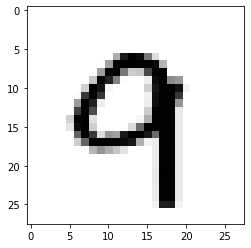

In [49]:
plt.imshow(X_test_prep[43].reshape(28,28), cmap='Greys')

In [50]:
print("Propability of all lables for given pixels: ", keras_cl_model.predict(X_test_prep[43].reshape(1,-1)))

Propability of all lables for given pixels:  [[1.1749340e-10 5.0075832e-10 2.0038147e-09 1.3065841e-06 1.7239643e-06
  3.0038166e-07 4.4249941e-11 1.2916138e-07 1.5389949e-08 9.9999654e-01]]


In [51]:
print("Predicted Digit: ",np.argmax(keras_cl_model.predict(X_test_prep[43].reshape(1,-1))))

Predicted Digit:  9


In [52]:
i = 1
for row in X_test_prep:
    index = i
    predicted_label = np.argmax(keras_cl_model.predict(row.reshape(1,-1)))

    mnist_competition_file = mnist_competition_file.append({'ImageId': index, 'Label': predicted_label}, ignore_index = True )
    i = i + 1
    pass

In [53]:
mnist_competition_file

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [54]:
mnist_competition_file.ImageId = mnist_competition_file.ImageId.astype(int)
mnist_competition_file.Label = mnist_competition_file.Label.astype(int)

In [55]:
mnist_competition_file.to_csv('mnist_submission.csv', index=False)